Reconhecimento de Padrões

Lista 5: Métodos estatatísticos e KNN


In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.model_selection import GridSearchCV, KFold
from itertools import product
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [166]:
bostonbin = pd.read_csv("content/bostonbin.csv", header=None)
print(bostonbin.shape)

new_columns = {old_col: f'x{i}' for i, old_col in enumerate(
    bostonbin.columns[:len(bostonbin.columns)])}
new_columns[bostonbin.columns[-1]] = 'target'

bostonbin = bostonbin.rename(columns=new_columns)

bostonbin.head()

(506, 18)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,target
0,2011.0,-70.955,42.2550,24.0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,1.0
1,2021.0,-70.950,42.2875,21.6,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,1.0
2,2022.0,-70.936,42.2830,34.7,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,1.0
3,2031.0,-70.928,42.2930,33.4,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,1.0
4,2032.0,-70.922,42.2980,36.2,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,1.0


In [167]:
class Metrics():
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred

        TP = 0
        FP = 0
        FN = 0

        for i in range(len(self.y_pred)):
            if self.y_true.values[i] == 1 and self.y_pred[i] == 1:
                TP += 1
            elif self.y_true.values[i] == 0 and self.y_pred[i] == 1:
                FP += 1
            elif self.y_true.values[i] == 1 and self.y_pred[i] == 0:
                FN += 1
        TN = len(self.y_true) - TP - FP - FN
        TP, FP, FN, TN

        self.TP = TP
        self.FP = FP
        self.FN = FN
        self.TN = TN

        self.accuracy = (self.TP + self.TN) / \
            (self.TP + self.FP + self.FN + self.TN)
        self.precision = self.TP / (self.TP + self.FP)
        self.recall = self.TP / (self.TP + self.FN)
        if (self.precision + self.recall) != 0:
            self.f1_score = 2 * (self.precision * self.recall) / \
                (self.precision + self.recall)

        self.confusion_matrix = np.array(
            [[self.TN, self.FN], [self.FP, self.TP]])

# Decision Tree

## Model

In [168]:
class Tree:
    def __init__(self, column=None, limiar=None, gini=None, left=None, right=None, is_leaf=False, leaf_value=None):
        # node
        self.column = column
        self.limiar = limiar
        self.gini = gini
        self.left = left
        self.right = right

        # leaf
        self.is_leaf = is_leaf
        self.leaf_value = leaf_value


class DecisionTree:
    def __init__(self, max_depth=3, min_leaf_samples=3, gini_stop=0, gini_step=1):
        self.gini_stop = gini_stop
        self.max_depth = max_depth
        self.min_leaf_samples = min_leaf_samples
        self.gini_step = gini_step
        self.tree = None

    def train(self, x, current_depth=0):
        column, limiar, gini = self.gini_calculator(x)

        x_left = x[x[column] > limiar]
        x_right = x[x[column] <= limiar]

        if (
            gini > self.gini_stop
            and current_depth < self.max_depth
            and len(x_left) >= self.min_leaf_samples
            and len(x_right) >= self.min_leaf_samples
        ):
            tree_left = self.train(x_left, current_depth=current_depth + 1)
            tree_right = self.train(x_right, current_depth=current_depth + 1)
            node = Tree(column=column, limiar=limiar,
                        gini=gini, left=tree_left, right=tree_right)
        else:
            leaf_value = x['target'].mode()[0]
            node = Tree(is_leaf=True, leaf_value=leaf_value)

        if current_depth == 0:
            self.tree = node
        return node

    def gini_calculator(self, x):
        gini_df = pd.DataFrame()
        for column in x.columns:
            if column != 'target' and x[column].std() > 0:
                colmax = x[column].max()
                colmin = x[column].min()

                num_steps = int((colmax - colmin) / self.gini_step) + 1
                limiares = np.linspace(colmin, colmax, num=num_steps)

                for limiar in limiares:
                    x_left = x[x[column] > limiar]
                    x_right = x[x[column] <= limiar]

                    counts = np.unique(x_left.target, return_counts=True)[1]
                    gini_left = 1 - np.sum((counts / len(x_left)) ** 2)

                    counts = np.unique(x_right.target, return_counts=True)[1]
                    gini_right = 1 - np.sum((counts / len(x_right)) ** 2)

                    gini = (gini_left * len(x_left) +
                            gini_right * len(x_right)) / len(x)

                    gini_df = pd.concat([gini_df, pd.DataFrame([{
                        'column': column, 'limiar': limiar, 'gini': gini
                    }])], ignore_index=True)

        best_row = gini_df.loc[gini_df['gini'].idxmin()]
        return best_row['column'], best_row['limiar'], best_row['gini']

    def predict(self, x):
        return x.apply(lambda row: self.traverse_tree(self.tree, row), axis=1)

    def traverse_tree(self, node, row):
        if node.is_leaf:
            return node.leaf_value
        if row[node.column] > node.limiar:
            return self.traverse_tree(node.left, row)
        else:
            return self.traverse_tree(node.right, row)

## Training

In [169]:
X_train, X_test = train_test_split(bostonbin, test_size=0.3, random_state=101)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [170]:
decision_tree = DecisionTree(
    max_depth=2, min_leaf_samples=10, gini_stop=0.3,  gini_step=1)

In [171]:
tree = decision_tree.train(X_train)

In [172]:
tree.leaf_value

np.float64(1.0)

In [173]:
y_pred = decision_tree.predict(X_test)
y_pred

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
147    1.0
148    1.0
149    1.0
150    1.0
151    1.0
Length: 152, dtype: float64

In [174]:
metric = Metrics(X_test.target, y_pred)

print(metric.accuracy)
print(metric.precision)
print(metric.recall)
print(metric.f1_score)

0.6578947368421053
0.6578947368421053
1.0
0.7936507936507937


In [208]:
def plot_roc_pr_curves(y_true, y_pred, title_prefix="Model"):
    """
    Function to plot ROC and Precision-Recall curves for a given model.
    """
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend(loc="lower right")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    avg_precision = average_precision_score(y_true, y_pred)

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color="blue", lw=2, label=f"Avg Precision = {avg_precision:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

In [209]:
def grid_search_decision_tree(X, param_grid, kfold_splits=2, plot=True):
    best_params = None
    best_score = -np.inf
    results = []
    
    param_combinations = list(product(*param_grid.values()))  
    kf = KFold(n_splits=kfold_splits, shuffle=True, random_state=42)
    
    print('Combinations=', len(param_combinations), 'kfolds=', kfold_splits)
    comb_count = 0
    
    for params in param_combinations:
        comb_count += 1
        param_dict = dict(zip(param_grid.keys(), params))
        all_y_true = []
        all_y_pred = []
        scores = []
        
        kfold_count = 0
        for train_idx, val_idx in kf.split(X):
            kfold_count += 1
            train_data = X.iloc[train_idx].reset_index(drop=True)
            val_data = X.iloc[val_idx].reset_index(drop=True)
            
            model = DecisionTree(
                max_depth=param_dict['max_depth'],
                min_leaf_samples=param_dict['min_leaf_samples'],
                gini_stop=param_dict['gini_stop'],
                gini_step=param_dict['gini_step']
            )
            model.train(train_data)
            
            y_pred = model.predict(val_data)
            
            metric = Metrics(val_data['target'], y_pred)
            scores.append(metric.f1_score)
            
            all_y_true.extend(val_data['target'])
            all_y_pred.extend(y_pred)
            
            print('comb:', comb_count, 'k:', kfold_count)
        
        mean_score = np.mean(scores)
        results.append((param_dict, mean_score, all_y_true, all_y_pred))
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = param_dict
    
    return best_params, best_score, results

In [ ]:
param_grid = {
    'max_depth': [2],
    'min_leaf_samples': [1],
    'gini_stop': [0],
    'gini_step': [2]
}

best_params, best_score, results = grid_search_decision_tree(bostonbin, param_grid, kfold_splits=2)

Combinations= 1 kfolds= 2
comb: 1 k: 1
comb: 1 k: 2
Best Parameters: {'max_depth': 2, 'min_leaf_samples': 1, 'gini_stop': 0, 'gini_step': 2}
Best Score: 0.8394276253547777


In [212]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 2, 'min_leaf_samples': 1, 'gini_stop': 0, 'gini_step': 2}
Best Score: 0.8394276253547777


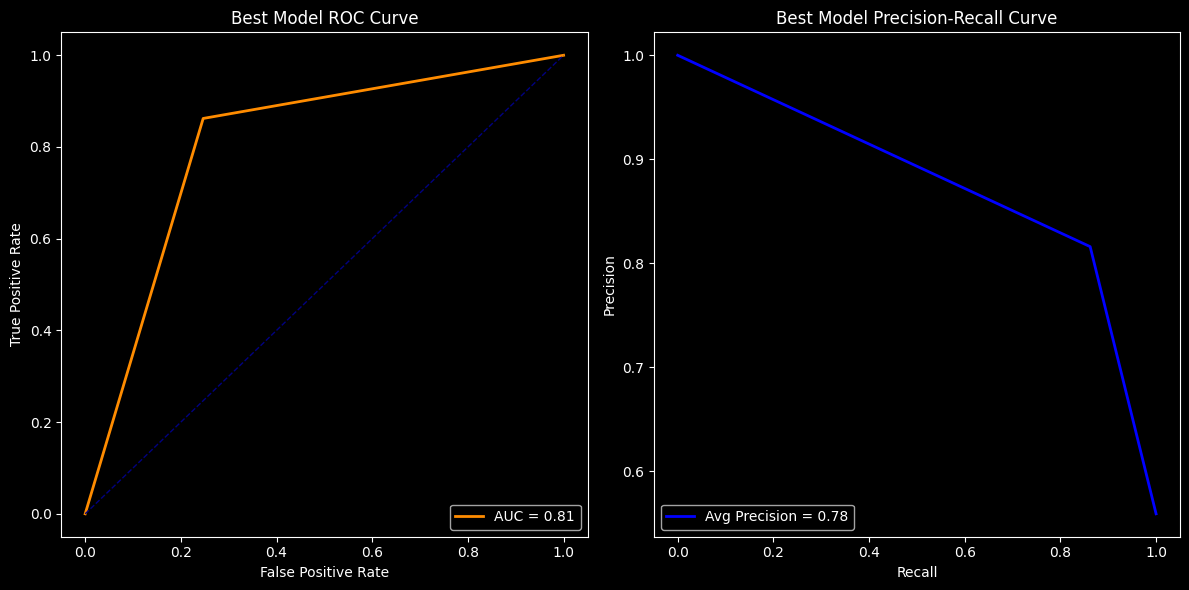

In [ ]:
best_model_results = max(results, key=lambda x: x[1]) 
plot_roc_pr_curves(best_model_results[2], best_model_results[3], title_prefix="Best Model")